In [4]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import glob
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as trns
import torch.nn as nn
from torchmetrics import JaccardIndex
from sklearn.model_selection import train_test_split

In [54]:
class CustomData(Dataset):
    def __init__(self, train=True):
        self.images = []
        self.masks = []
        folders = glob.glob("../data/*")
        for f in folders:
            files = glob.glob(f"{f}/*")
            self.images.append(glob.glob(f"{files[0]}/*")); self.masks.append(glob.glob(f"{files[1]}/*"))
        self.images= np.array(self.images).reshape(-1); self.masks = np.array(self.masks).reshape(-1)
        X_train, X_test, y_train, y_test = train_test_split(self.images, self.masks, test_size=0.2, shuffle=True)
        self.np_images = []
        self.np_masks = []
        trans = trns.Compose([trns.ToTensor(), trns.Resize((256,256))])
        if train:
            for li, lm in zip(X_train, y_train):
                self.np_images.append(trans(plt.imread(li)))
                self.np_masks.append(trans(plt.imread(lm))[:3, :, :])
        else:
            for li, lm in zip(X_test, y_test):
                self.np_images.append(trans(plt.imread(li)))
                self.np_masks.append(trans(plt.imread(lm))[:3, :, :])        
        
    def __getitem__(self, index) :
        return self.np_images[index], self.np_masks[index]
    def __len__(self):
        return len(self.np_images)

In [55]:
Train_data = CustomData()
Test_data = CustomData(False)

In [58]:
train_loader = DataLoader(Train_data, 1, True)
test_loader= DataLoader(Test_data, 1, shuffle=True)

In [59]:
x = next(iter(train_loader))

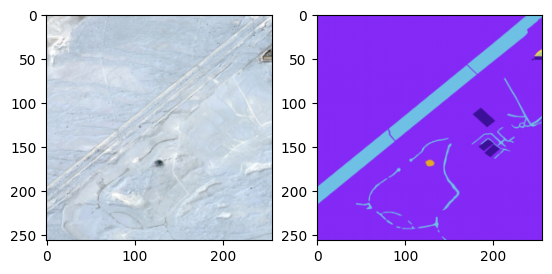

In [60]:

plt.subplot(1,2,1)
plt.imshow(x[0][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(x[1][0].permute(1,2,0))

In [212]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=3, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x
    

# Get UNet model
model = UNet()

In [213]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceloss, self).init()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [214]:
TRAINING = True

# Set num of epochs
EPOCHS = 12

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])
criterion = diceloss()
# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)




In [215]:
def Train_model(
        model,
        data_loader,
        criterion,
        optim,
        accuracy,
):
    losses= []
    accS = []
    model.train()
    for img , msk in data_loader:
        img, msk = img.to(DEVICE), msk.to(DEVICE)

        logits = model(img)
        loss = criterion(msk, logits)
        props = nn.functional.softmax(logits, dim=1).cpu()
        acc = accuracy(msk.cpu(), props)
        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.detach().cpu()); accS.append(acc.detach().cpu())
    print(f"Train Loss: {np.array(losses).mean() :.4f} | Train Acc: {np.array(accS).mean()*100 :2f}%")
    return np.array(losses).mean(), accS

def Test_model(
        model,
        data_loader,
        criterion,
        accuracy,):
    losses, accS = [], []
    model.eval()
    with torch.inference_mode():
        for img, msk in data_loader:
            img, msk = img.to(DEVICE), msk.to(DEVICE)
            logits = model(img)
            loss = criterion(logits, msk)
            props= nn.functional.softmax(logits, dim=1).cpu()
            acc = accuracy(msk.cpu().detach(), props)
            losses.append(loss.detach().cpu()); accS.append(acc.detach().cpu())
        print(f"Train Loss: {np.array(losses).mean() :.4f}")
        return np.array(losses).mean(), accS

In [216]:
losses = []
cmS = []
tlosses=[]
tcmS = []

In [217]:
from torchmetrics import Accuracy

In [218]:
CM = Accuracy(task="multiclass", num_classes=6)

In [219]:
model.to(DEVICE)
for i in range(100):
    print(f"{'#'*20} Epoch {i} {'#'*20}")
    print("Training....")
    l, cm = Train_model(model, train_loader, criterion, optimizer, CM)
    losses.append(l); cmS.append(cm)
    print("Testing.......")
    lt, cmt = Test_model(model, test_loader, criterion, CM)
    tlosses.append(lt); tcmS.append(cmt)   


#################### Epoch 0 ####################
Training....
Train Loss: 0.7228 | Train Acc: 0.000000%
Testing.......
Train Loss: 0.3618
#################### Epoch 1 ####################
Training....
Train Loss: 0.2518 | Train Acc: 0.000000%
Testing.......
Train Loss: 0.1720
#################### Epoch 2 ####################
Training....
Train Loss: 0.1531 | Train Acc: 0.000000%
Testing.......
Train Loss: 0.0819
#################### Epoch 3 ####################
Training....
Train Loss: 0.1100 | Train Acc: 0.000000%
Testing.......
Train Loss: 0.0569
#################### Epoch 4 ####################
Training....
Train Loss: 0.0854 | Train Acc: 0.000000%
Testing.......
Train Loss: 0.0420
#################### Epoch 5 ####################
Training....
Train Loss: 0.0781 | Train Acc: 0.000000%
Testing.......
Train Loss: 0.0370
#################### Epoch 6 ####################
Training....
Train Loss: 0.0716 | Train Acc: 0.000000%
Testing.......
Train Loss: 0.0352
#################### Epoch 

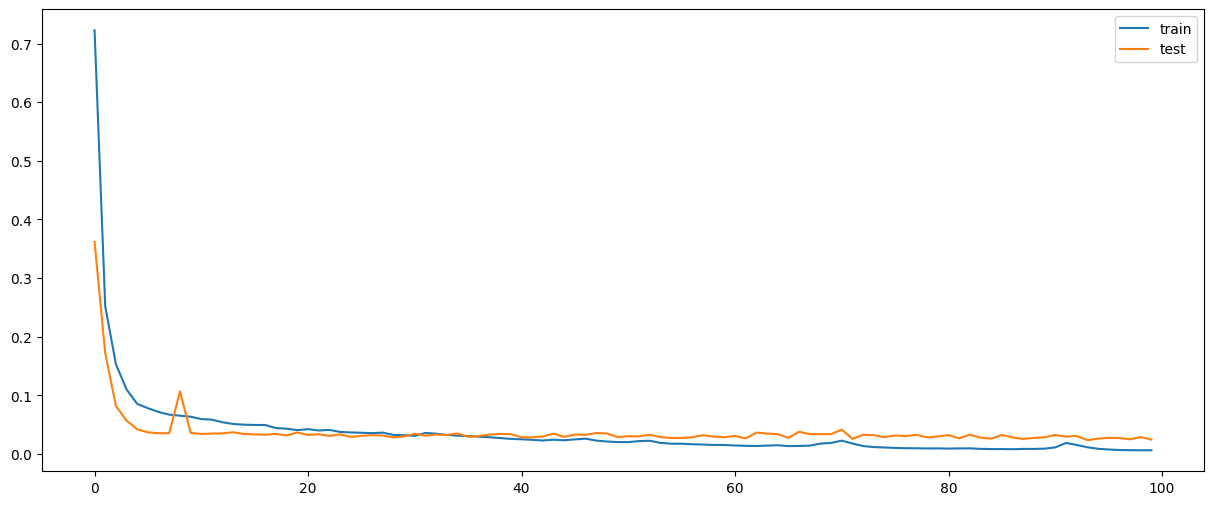

In [233]:
plt.figure(figsize=(15,6))
plt.plot(losses, label="train")
plt.plot(tlosses, label="test")
plt.legend()

In [221]:
d = iter(test_loader)

In [243]:
x = next(d)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


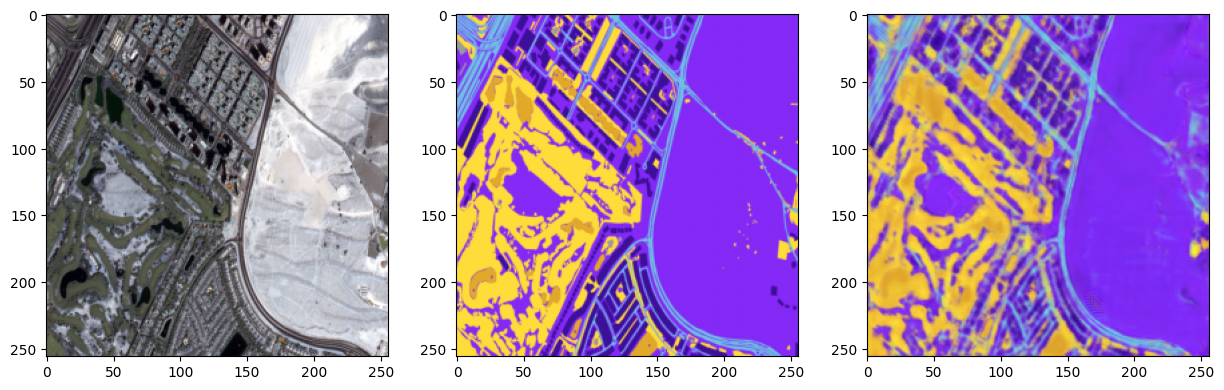

In [244]:
model.eval()
with torch.no_grad():
    pred = model(x[0][0].unsqueeze(0).to(DEVICE))

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(x[0].squeeze().permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(x[1].squeeze().permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(pred.squeeze().permute(1,2,0).cpu())

In [123]:
with torch.no_grad():
    pred = model(x[0].to(DEVICE))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


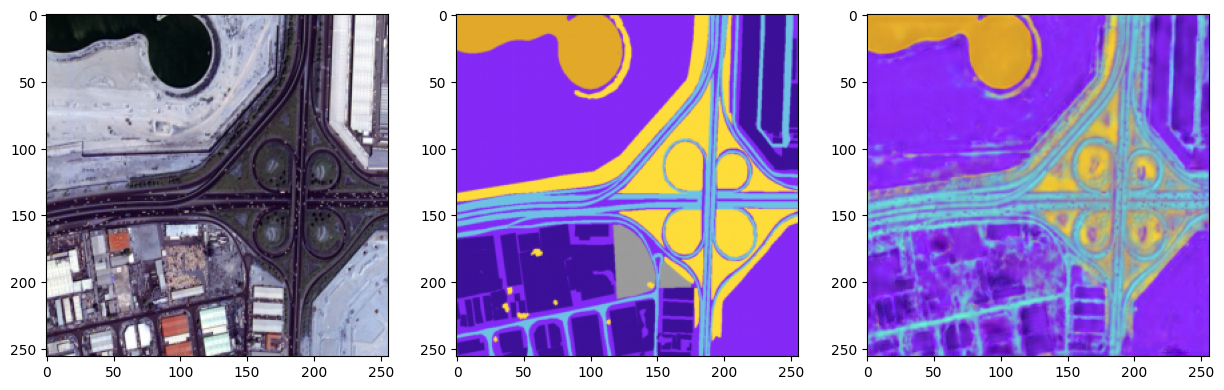

In [124]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(x[0].squeeze().permute(1,2,0))

plt.subplot(1,3,2)
plt.imshow(x[1].squeeze().permute(1,2,0))

plt.subplot(1,3,3)
plt.imshow(pred.cpu().squeeze().permute(1,2,0))


# segementation metrics 

#### Accuracy, Validation Accuracy, Loss, Validation Loss, IoU, Validation IoU

# hypred model 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


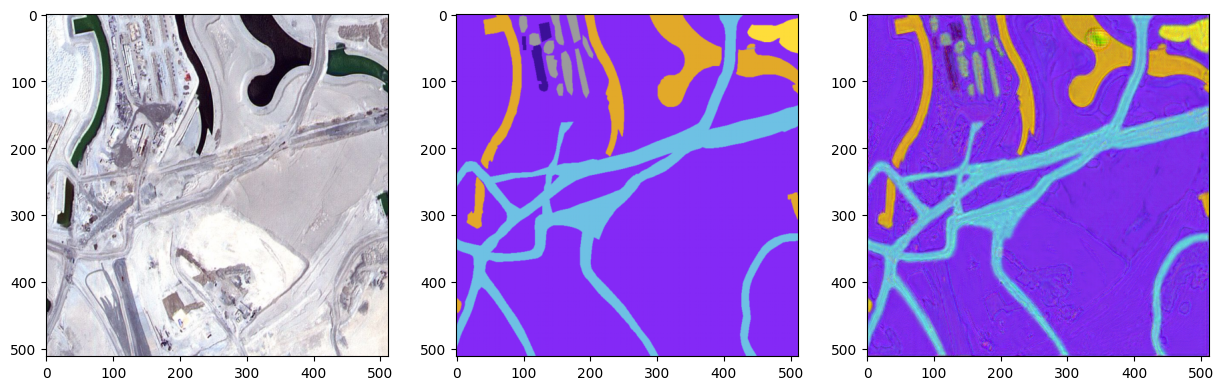

In [39]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(x[0].squeeze().permute(1,2,0))

plt.subplot(1,3,2)
plt.imshow(x[1].squeeze().permute(1,2,0))

plt.subplot(1,3,3)
plt.imshow(pred.cpu().squeeze().permute(1,2,0))
